In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
#from cartopy import crs, feature
from datetime import datetime, timedelta
import cmocean
from matplotlib import pyplot as plt, animation, rc,colors
from IPython.display import Image
rc('animation', html='html5')
import os
import sys
import re

In [2]:
path_run = '/results2/SalishSea/nowcast-green.202111' 

In [3]:
M_path = '/home/jvalenti/MOAD/'
coords = xr.open_dataset(M_path+'grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset(M_path+'grid2/mesh_mask202108_TDV.nc')
lon = coords.nav_lon
x= np.linspace(0,lon.shape[1],lon.shape[1])
y = np.linspace(0,lon.shape[0],lon.shape[0])
X,Y = np.meshgrid(x,y)

In [4]:
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [5]:
def make_filename(path,start,day, var='prod_T', res='h'):
    """Construct path prefix for local SHEM results given date object and paths dict
    """
    date  =  (start + timedelta(days=day))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path_run, f'{folder}/')
    fname = []
    for file in os.listdir(prefix):
        if (var in file) and ('_1'+res) in file:
            fname.append(file)
    if len(fname)>1:
        print('more than one file found') 
    
    return os.path.join(prefix, fname[0])


In [6]:
day = 181
start = datetime(2021,1,1)
make_filename(path_run,start,day, var='prod_T', res='d')

'/results2/SalishSea/nowcast-green.202111/01jul21/SalishSea_1d_20210701_20210701_prod_T.nc'

In [7]:
#prod = xr.open_dataset(make_filename(path_run,start,day, var='prod_T', res='d')).HetHBAC
#Nat_mort = xr.open_dataset(make_filename(path_run,start,day, var='graz_T', res='d')).MORTHBAC
#Mic_graz = xr.open_dataset(make_filename(path_run,start,day, var='graz_T', res='d')).GRMICZHBAC
PP0 = xr.open_dataset(make_filename(path_run,start,0, var='prod_T', res='d')).PPDIAT
PP = xr.open_dataset(make_filename(path_run,start,day, var='prod_T', res='d')).PPDIAT


Ox0 = xr.open_dataset(make_filename(path_run,start,0, var='chem_T')).dissolved_oxygen
Ox = xr.open_dataset(make_filename(path_run,start,day, var='chem_T')).dissolved_oxygen
DIC = xr.open_dataset(make_filename(path_run,start,day, var='chem_T')).dissolved_inorganic_carbon



NH4 = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).ammonium
NH40 = xr.open_dataset(make_filename(path_run,start,0, var='biol_T')).ammonium
diat0 = xr.open_dataset(make_filename(path_run,start,0, var='biol_T')).diatoms
diat = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).diatoms

NO3 = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).nitrate
flag0 = xr.open_dataset(make_filename(path_run,start,0, var='biol_T')).flagellates
flag = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).flagellates

#hbac = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).heterotrophic_bacteria
DOM = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).dissolved_organic_nitrogen
DOM0 = xr.open_dataset(make_filename(path_run,start,0, var='biol_T')).dissolved_organic_nitrogen
POM = xr.open_dataset(make_filename(path_run,start,day, var='biol_T')).particulate_organic_nitrogen
POM0 = xr.open_dataset(make_filename(path_run,start,0, var='biol_T')).particulate_organic_nitrogen

In [8]:
Orray = np.array(Ox[0,:,:,:])
def findanox(Orray):
    oflat =Orray.flatten()
    positions = np.where((oflat<65) & (oflat>0))
    coords = np.unravel_index(positions[0], Orray.shape)

    xy = []
    for ind in range(coords[0].shape[0]):
        xy.append((coords[1][ind],coords[2][ind]))
    set_coord = set(xy)
    xx = []
    yy = []
    for tup in set_coord:
        yy.append(tup[0])
        xx.append(tup[1])
    return xx,yy

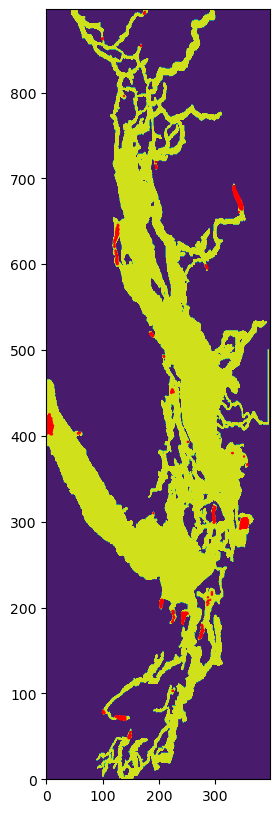

In [9]:
plt.figure(figsize=(10,10))
plt.contourf(mask.tmask[0,0,:,:])
xx,yy = findanox(Orray)
plt.scatter(xx,yy,s=np.ones(len(yy))*0.5,color='red')
f = 1.0/np.cos(49*np.pi/180)
plt.gca().set_aspect(f)

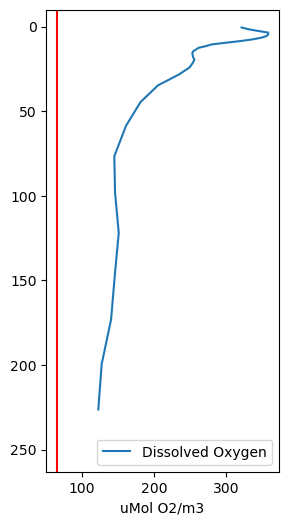

In [10]:
jj,ii = finder(48.58042615605835, -123.50289311333903)
zz = np.argmin(np.array(mask.tmask[-1,:,jj,ii]))
fig,axs=plt.subplots(1,figsize=(3,6))
plt.plot(Ox[-1,:zz,jj,ii],Ox.deptht[:zz],label='Dissolved Oxygen')
plt.axvline(x = 65,color = 'red')

plt.ylim([Ox.deptht[zz]+10,-10])
plt.xlabel('uMol O2/m3')
plt.legend()

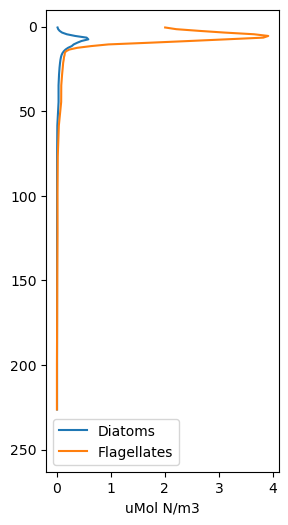

In [11]:
#jj,ii = finder(49.286779538295114, -123.74497535526103)
fig,axs=plt.subplots(1,figsize=(3,6))
#plt.plot(hbac[-1,:zz,jj,ii],hbac.deptht[:zz],label='Het.bacteria')
plt.plot(diat[-1,:zz,jj,ii],diat.deptht[:zz],label='Diatoms')
plt.plot(flag[-1,:zz,jj,ii],diat.deptht[:zz],label='Flagellates')

plt.ylim([diat.deptht[zz]+10,-10])
plt.xlabel('uMol N/m3')
plt.legend()

In [12]:
DOM_notz = np.array(DOM[0,:,:,:]).flatten()
DOM_notz=DOM_notz[DOM_notz!=0]
np.nanmean(DOM_notz)

np.float32(1.6140673)

In [13]:
def steadystate(file='biol_T',var = 'heterotrophic_bacteria',res=1):
    startT = datetime(2021, 1, 1)
    lenT = 3600 #hours from start to run
    
    filelib = {}
    hbac =[]

    for days in range(0,1+(lenT-1)//24,res):
        timeT = startT + timedelta(days=days)
        ti = timeT.strftime('%Y%m%d')  
        filelib[days,var]= xr.open_dataset(make_filename(path_run,startT,days, file, res='h'))[var]
        hbac.append(np.nansum(np.array(filelib[days,var][0,:,:,:]).flatten()))
    plt.plot(hbac)

In [26]:
plotslib = {'chem_T':{'var':['dissolved_oxygen'],'res':'h'},
        'biol_T':{'var':['diatoms','particulate_organic_nitrogen','dissolved_organic_nitrogen','ammonium','nitrate','flagellates','microzooplankton','mesozooplankton'],'res':'h'},
        'prod_T':{'var':['PPDIAT','PPPHY'],'res':'d'}
        }
variables = ['O2','Diat','PON','DON','NH4','NO3','Flag','Z1','Z2','PPDiat','PPPhy']
startT = datetime(2021, 1, 1)
lenT = 4344 #hours from start to run
#lenT = 300
res = 10
depths = [0,50,200]
shal_int = np.where(mask.gdept_1d[0]>50)[0][0]
int_deep = np.where(mask.gdept_1d[0]>200)[0][0]
depths_k = [0,shal_int,int_deep]

filelib = {}
count = np.zeros([len(variables),int((lenT//24)/res)+1,len(depths)])
for i,days in enumerate(range(0,1+(lenT-1)//24,res)):
    ccc = 0
    for c,files in enumerate(plotslib):
        filelib[days,files]= xr.open_dataset(make_filename(path_run,startT,days, files, res=plotslib[files]['res']))
        for j,var in enumerate(plotslib[files]['var']):
            ccc += 1
            for zk in range(len(depths)):
                if zk ==0:#SHALLOW
                    count[ccc-1,i,zk]=(np.nansum(np.array(filelib[days,files][var][0,:shal_int,:,:]).flatten()*np.array(mask.volume[:shal_int,:,:]).flatten()))
                if zk ==1:#Intermediate
                    count[ccc-1,i,zk]=(np.nansum(np.array(filelib[days,files][var][0,shal_int:int_deep,:,:]).flatten()*np.array(mask.volume[shal_int:int_deep,:,:]).flatten()))
                if zk ==2:#Deep
                    count[ccc-1,i,zk]=(np.nansum(np.array(filelib[days,files][var][0,int_deep:,:,:]).flatten()*np.array(mask.volume[int_deep:,:,:]).flatten()))
                    

In [30]:
np.save('202111_jan-jul_new.npy',count)

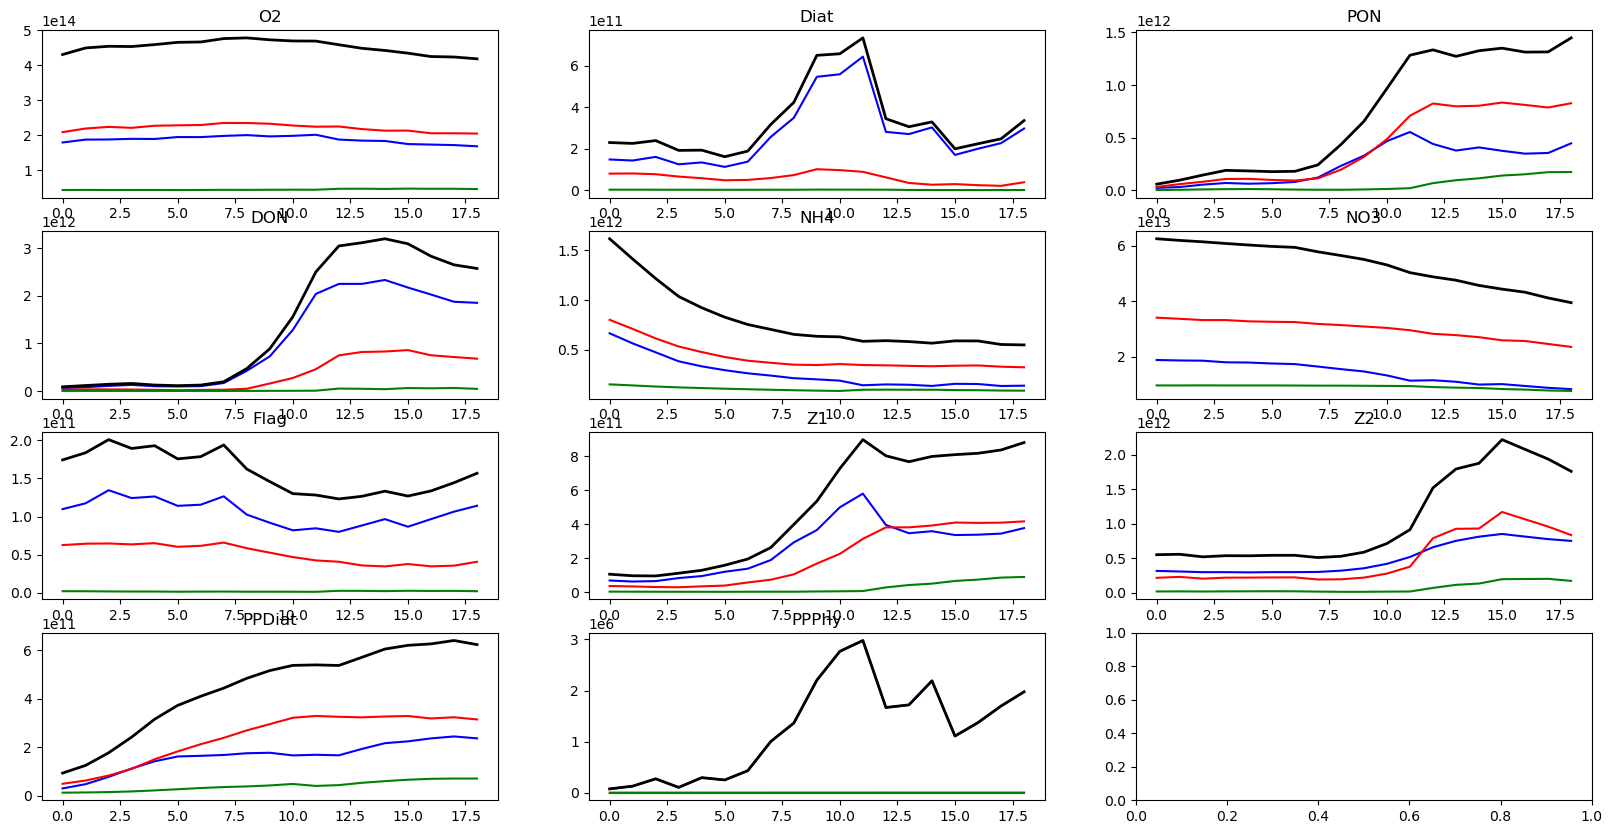

In [31]:
def plot1_subplots(data_list,data,ncols=2, figsize=(12, 12)):
    colors = ['blue','red','green']
    nplots = len(data_list)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # flatten in case of multi-row
    depths_n = ['Shallow','Intermediate','Deep','Total']
    for i, variable in enumerate(data_list):
        for j in range(data.shape[2]):
            axes[i].plot(data[i, :, j], label=f"{depths_n[j]}",color=colors[j])
            
        
        # Plot the sum across the 3rd dimension
        axes[i].plot(data[i, :, :].sum(axis=1), label=depths_n[-1], linewidth=2, color="k")        
        axes[i].set_title(variable)
        #axes[i].legend()

        # axes[i].plot(data[i,:])
        # axes[i].set_title(f"{variable}")
        
plot1_subplots(variables,count, ncols=3, figsize=(20, 10))

In [17]:
#np.save('SHEM_jan-jul_CSoG.npy',count)

In [34]:
count = np.load('SHEM_jan-jul_new.npy')
count2 = np.load('202111_jan-jul_new.npy')

plotslib = {'chem_T':{'var':['dissolved_oxygen']},
        'biol_T':{'var':['diatoms','particulate_organic_nitrogen','dissolved_organic_nitrogen','ammonium','nitrate','flagellates','microzooplankton','mesozooplankton','heterotrophic_bacteria']}
        }
variables2 = ['O2','Diat','PON','DON','NH4','NO3','Flag','Z1','Z2','PPDiat','PPPhy']

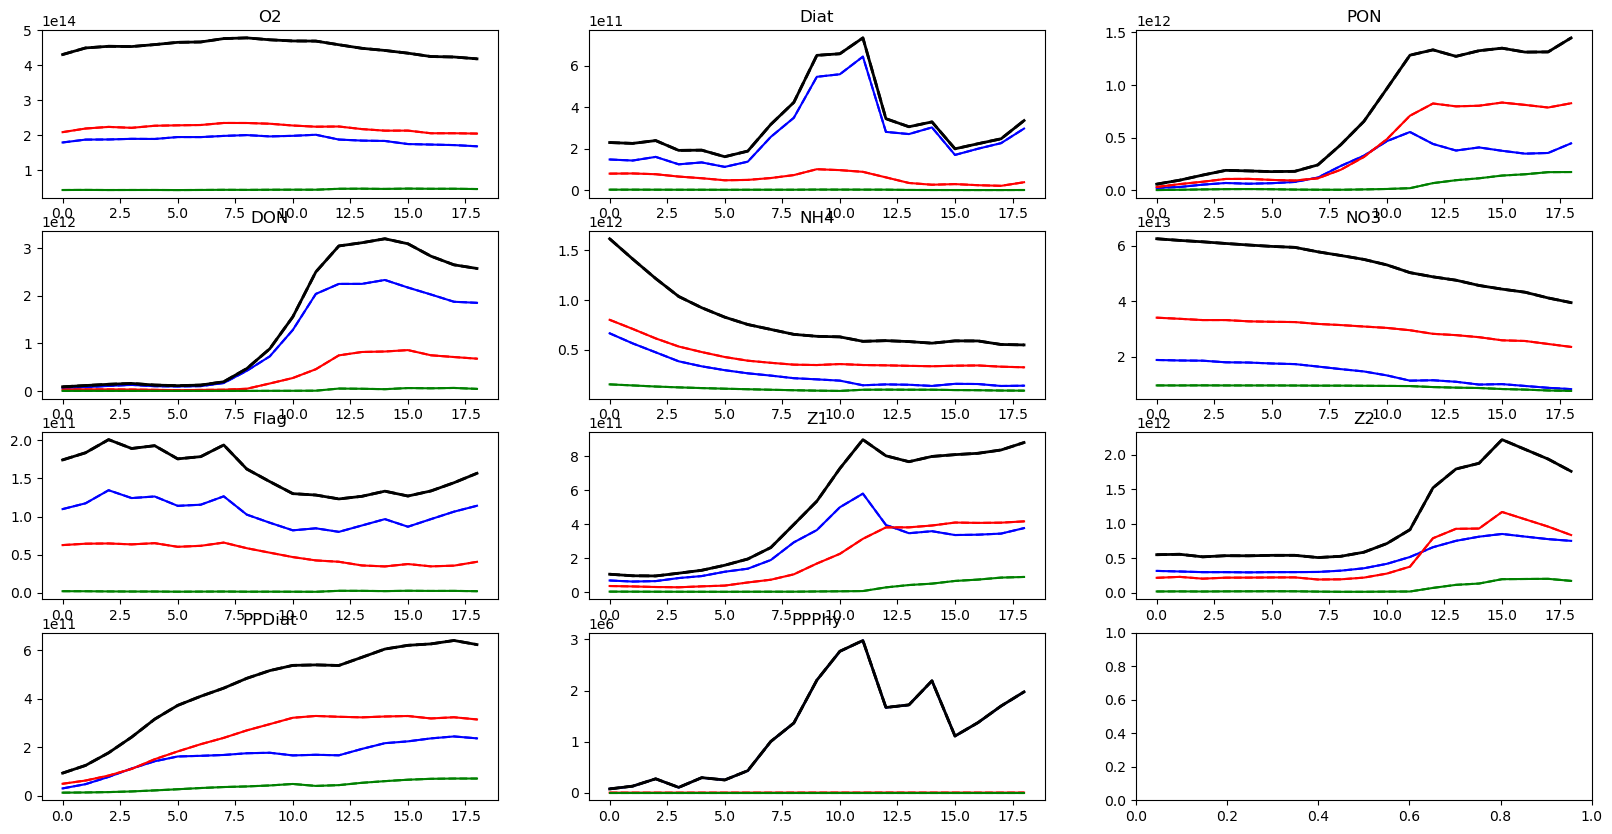

In [35]:
def plot_subplots(data_list,data, data2,ncols=2, figsize=(12, 12)):
    colors = ['blue','red','green']
    nplots = len(data_list)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # flatten in case of multi-row
    depths_n = ['Shallow','Intermediate','Deep','Total']
    for i, variable in enumerate(data_list):
        for j in range(data.shape[2]):
            axes[i].plot(data[i, :, j], label=f"{depths_n[j]}",color=colors[j])
            axes[i].plot(data2[i, :, j], label=f"{depths_n[j]}",color=colors[j],linestyle='--')
            
        
        # Plot the sum across the 3rd dimension
        axes[i].plot(data[i, :, :].sum(axis=1), label=depths_n[-1], linewidth=2, color="k")
        axes[i].plot(data2[i, :, :].sum(axis=1), label=depths_n[-1], linewidth=2, color="k",linestyle='--')
        

        axes[i].set_title(variable)
        #axes[i].legend()

        # axes[i].plot(data[i,:])
        # axes[i].set_title(f"{variable}")
        
plot_subplots(variables2,count2,count, ncols=3, figsize=(20, 10))
